# Ridge Regression

## I - Ridge Regression From Scratch 

### Libraries Imports 

In [62]:
import numpy as np 
from Preprocess import load_and_preprocess_ozone
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import Ridge 

### Data Vizualisation

In [63]:
# Load the preprocess data
ozone_data = load_and_preprocess_ozone()

# Display the 5 first rows of the dataframe
ozone_data.head(5)

,T6,T9,T12,T15,T18,Ne6,Ne9,Ne12,Ne15,Ne18,...,Vdir9,Vvit9,Vdir12,Vvit12,Vdir15,Vvit15,Vdir18,Vvit18,Vx,maxO3
"""19950401""",-0.659783,-1.351138,-1.437475,-1.461015,-1.487282,1.010337,1.103807,1.148543,1.223430,1.253349,...,0.858399,0.177065,0.886152,-0.215542,1.185441,-0.361338,-1.393239,-0.197596,-0.825319,47.6
"""19950402""",-0.829866,-1.964249,-1.320948,-0.645784,-0.569076,1.010337,1.103807,0.704860,-2.260515,-1.795046,...,-0.350600,-0.940824,-0.248588,-0.730652,-0.884524,-1.908708,1.315175,-1.377590,0.243576,56.2
"""19950403""",-2.502354,-2.354411,-0.621788,0.233807,0.304339,-0.388209,-0.106502,-1.513560,-1.389528,-0.651898,...,-1.652599,-0.940824,1.264399,-1.760872,-0.344533,-1.392918,-0.162141,-0.787593,0.138047,61.8
"""19950404""",-0.829866,-1.657693,-1.880276,-1.761364,-1.666444,1.010337,0.700371,0.704860,0.787937,1.253349,...,-1.745599,0.177065,1.358961,-0.730652,1.275439,-0.877128,1.315175,-0.197596,0.082845,50.8
"""19950405""",-0.744825,-1.574087,-1.320948,-1.310841,-1.240934,1.010337,0.700371,1.148543,1.223430,0.872300,...,1.323398,-0.940824,0.697029,-1.760872,1.005444,-0.877128,1.315175,-0.197596,-0.060298,59.8


In [64]:
# Calculate descriptive statistics for maxO3
maxO3_stats = ozone_data["maxO3"].describe()

print("Descriptive statistics for maxO3 :")
print(maxO3_stats)

Descriptive statistics for maxO3 :
count    1269.000000
mean       83.081481
std        21.035921
min        33.200000
25%        67.800000
50%        80.000000
75%        96.000000
max       143.000000
Name: maxO3, dtype: float64


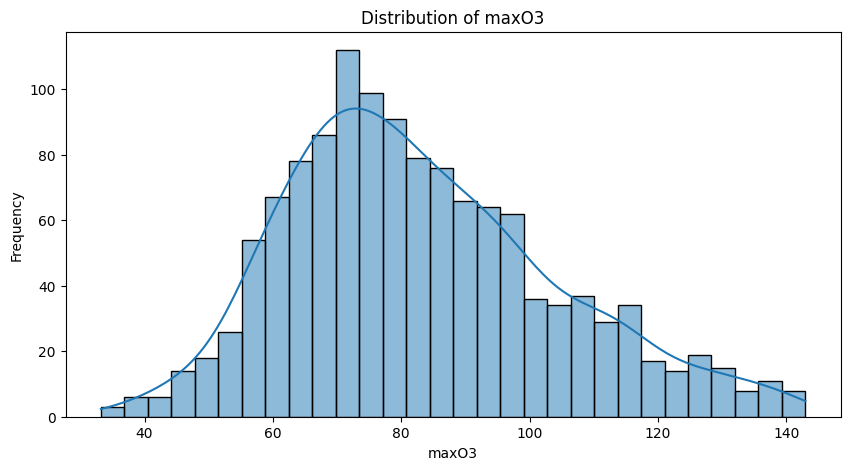

In [65]:
# maxO3 histogram
plt.figure(figsize=(10, 5))
sns.histplot(ozone_data['maxO3'], bins=30, kde=True)
plt.title('Distribution of maxO3')
plt.xlabel('maxO3')
plt.ylabel('Frequency')
plt.show()

On observe une asymétrie à droite en plus de valeurs extrêmes, on applique alors une transformation logarithmique afin de rendre la distribution plus symétrique. 

count    1269.000000
mean        4.387999
std         0.253669
min         3.502550
25%         4.216562
50%         4.382027
75%         4.564348
max         4.962845
Name: log_maxO3, dtype: float64


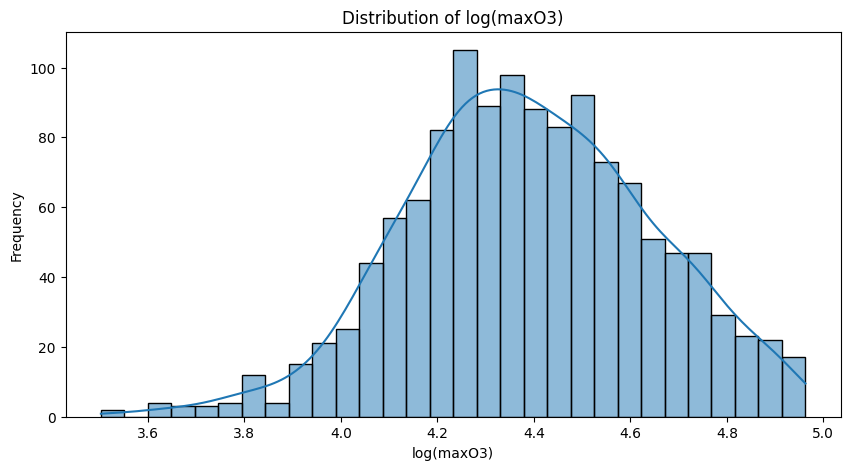

In [66]:
# Apply the logarithmic transformation to maxO3 
ozone_data['log_maxO3'] = np.log(ozone_data['maxO3'])

# Check the new descriptive statistics 
print(ozone_data['log_maxO3'].describe())

# Visualise distribution after transformation
plt.figure(figsize=(10, 5))
sns.histplot(ozone_data['log_maxO3'], bins=30, kde=True)
plt.title('Distribution of log(maxO3)')
plt.xlabel('log(maxO3)')
plt.ylabel('Frequency')
plt.show()

Les statistiques descriptives de log_maxO3 montrent une legère amélioration par rapport à la distribution originale de maxO3. 

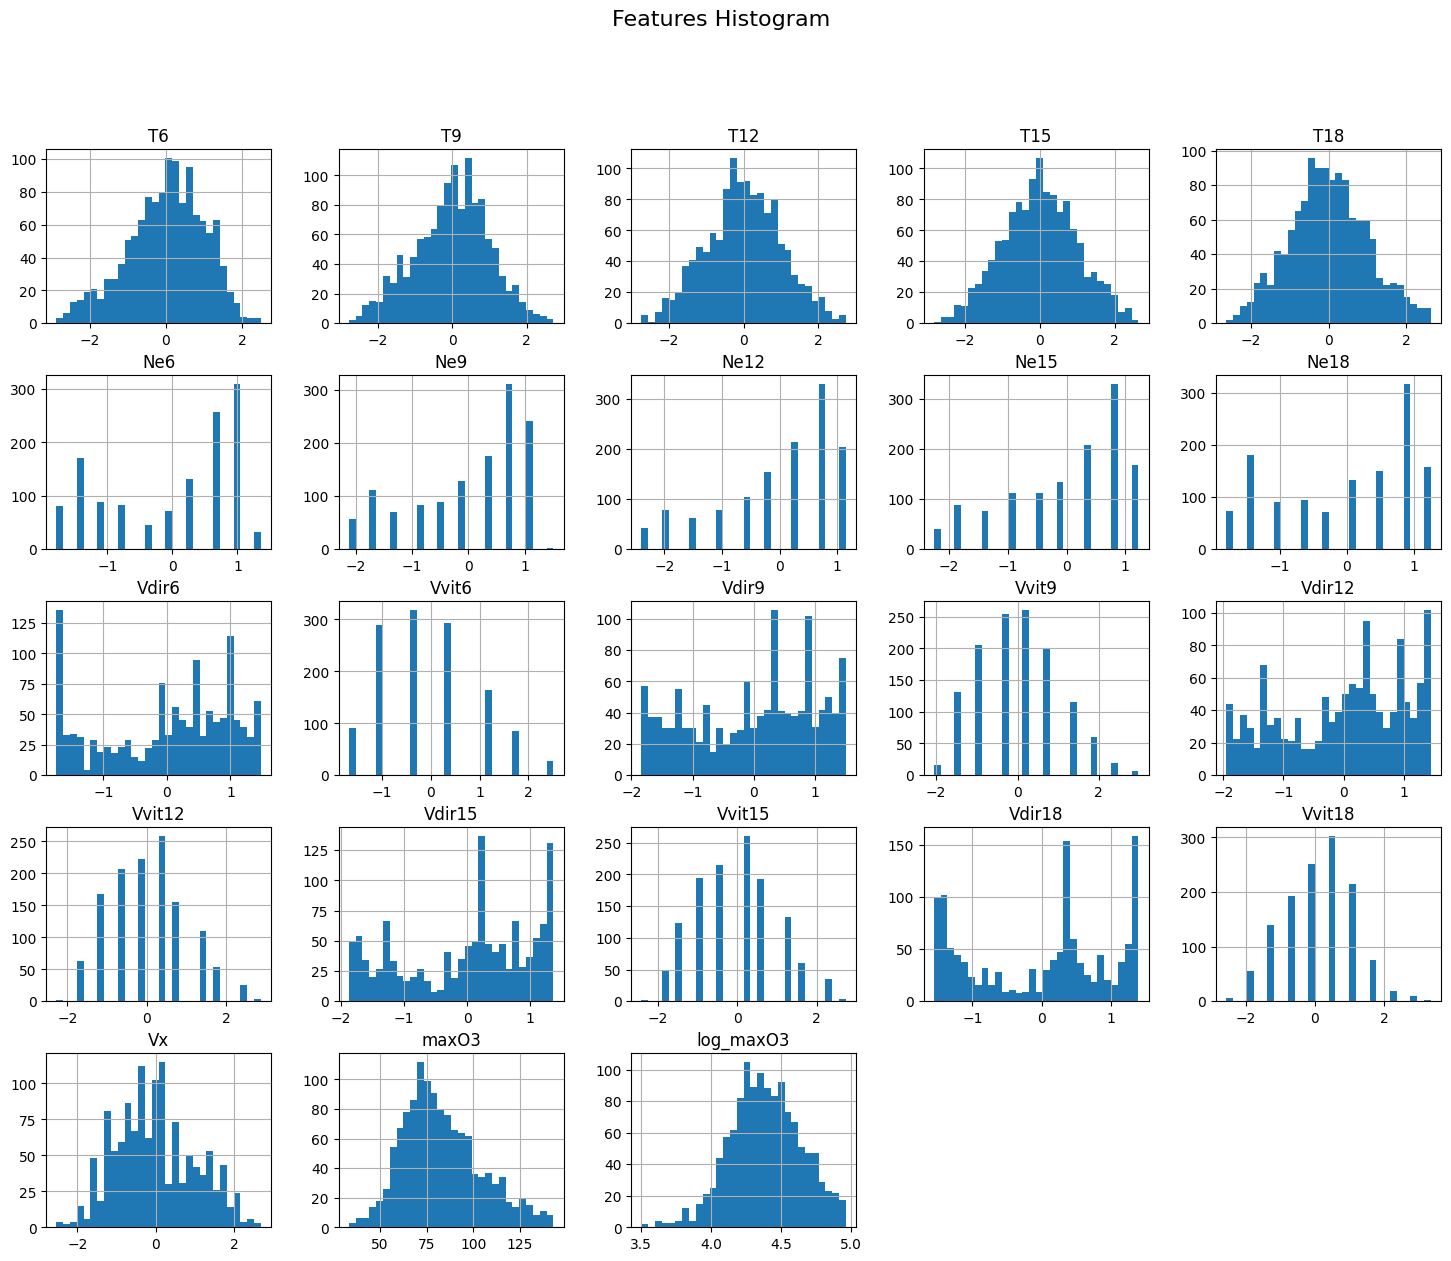

In [67]:
# Vizualize the data 
def plot_histograms(data):
    data.hist(bins=30, figsize=(18, 14))
    plt.suptitle('Features Histogram', fontsize=16)
    plt.show()

plot_histograms(ozone_data)

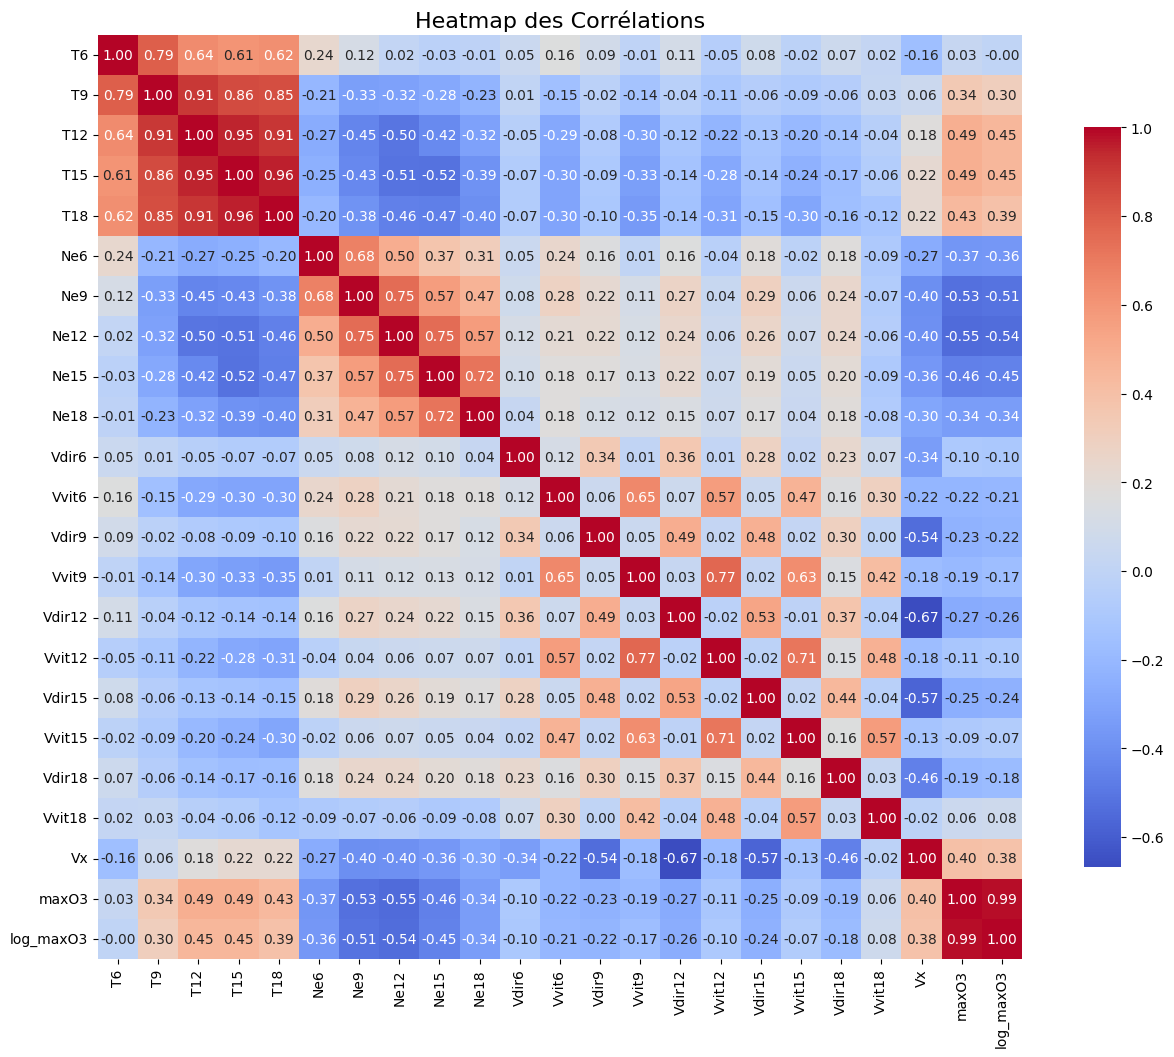

In [68]:
def plot_correlation_heatmap(data):
    plt.figure(figsize=(16, 12))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Heatmap des Corrélations', fontsize=16)
    plt.show() 

plot_correlation_heatmap(ozone_data)

On observe des valeurs de corrélations faibles entre des features et la target ainsi que des fortes corrélations entre des features, on va donc les supprimés

### Function to remove features that are too closely correlated

In [69]:
def remove_unimportant_features(data, correlation_threshold=0.7, target_correlation_threshold=0.1, target_variable='log_maxO3'):
    # Calculate the correlation matrix
    correlation_matrix = data.corr().abs()  # Use absolute values of correlations
    
    # Identify columns to drop due to high correlation with each other
    to_drop = set()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] > correlation_threshold:
                colname = correlation_matrix.columns[i]
                # Do not drop the target variable
                if colname != target_variable:
                    to_drop.add(colname)

    # Print columns that will be removed due to high correlation
    print("Columns to drop due to high correlation:", to_drop)
    
    # Drop identified columns, but keep the target variable
    cleaned_data = data.drop(columns=to_drop)

    # Calculate the correlation with the target variable
    target_corr = cleaned_data.corr()[target_variable].abs()  # Assuming 'log_maxO3' is the target

    # Identify features with low correlation to the target
    low_correlation_features = target_corr[target_corr < target_correlation_threshold].index.tolist()
    
    # Print columns that will be removed due to low correlation with the target
    print("Columns to drop due to low correlation with the target:", low_correlation_features)
    
    # Drop these low correlation features, but keep the target variable
    low_correlation_features = [col for col in low_correlation_features if col != target_variable]
    cleaned_data = cleaned_data.drop(columns=low_correlation_features)

    return cleaned_data

# Use example 
ozone_data = load_and_preprocess_ozone()  # Load the preprocess data 
ozone_data['log_maxO3'] = np.log(ozone_data['maxO3'])
cleaned_ozone_data = remove_unimportant_features(ozone_data, correlation_threshold=0.8, target_correlation_threshold=0.1)

Columns to drop due to high correlation: {'T15', 'T12', 'T18'}
Columns to drop due to low correlation with the target: ['T6', 'Vvit12', 'Vvit15', 'Vvit18']


### 1. Ridge Regression Class

In [70]:
class RidgeRegression: 
    def __init__(self, penality, degree=1):
        self.penality = penality
        self.degree = degree

    def _polynomial_features(self, X):
        features = [X]  # Start with the original features
        for d in range(2, self.degree + 1):  # Start from degree 2 to the specified degree
            features.append(X ** d)  # Add each polynomial feature
        return np.hstack(features)  # Concatenate all features

    def fit(self, X, y):
        samples_nb = X.shape[0]
        X_poly = self._polynomial_features(X)  # Generate polynomial features
        X_with_intercept = np.c_[np.ones((samples_nb, 1)), X_poly]  # Add intercept

        identity_matrix = np.identity(X_with_intercept.shape[1]) 
        identity_matrix[0, 0] = 0  # Do not regularise the intercept

        # Calculation of the matrices A and B for Ridge's solution
        A = X_with_intercept.T.dot(X_with_intercept) + self.penality * identity_matrix
        B = X_with_intercept.T.dot(y)
        self.thetas = np.linalg.solve(A, B)  # Solve for the parameters
        
        return self

    def predict(self, X): 
        samples_nb = X.shape[0]
        X_poly = self._polynomial_features(X)  # Generate polynomial features for predictions
        X_with_intercept = np.c_[np.ones((samples_nb, 1)), X_poly]
        predictions = X_with_intercept.dot(self.thetas)  # Calculate predictions
        return predictions 
    
    # Required for scikit-learn compatibility
    def get_params(self, deep=True):
        return {"penality": self.penality, "degree": self.degree}

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

### 2. Run the Model

In [71]:
def runRidgeRegressionFromScratch(penality=1.0): 
    # Load the preprocessed data 
    data = load_and_preprocess_ozone()

    # Apply the logarithmic transformation to maxO3
    data['log_maxO3'] = np.log(data['maxO3'])

    # Remove features that are too closely correlated
    ozone_data = remove_unimportant_features(data) 

    X = ozone_data.drop('log_maxO3', axis=1)  # Features
    y = ozone_data['log_maxO3']  # Target variable

    # Split the data into training and testing sets (80% | 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=False)

    # Creation and fitting of the Ridge regression model
    model = RidgeRegression(penality=penality)  # Use the penality as a parameter 
    model.fit(X_train.values, y_train.values) # Model learning

    # Predictions on test data
    predictions_fromscratch = model.predict(X_test.values)

    # Display the first 10 predictions and true values
    print("First 10 Predictions (from Scratch):", predictions_fromscratch[:10])
    print("First 10 True Values:", y_test.values[:10])
    
    return predictions_fromscratch, y_test.values, model, X_train, y_train

### 3. Ridge Regression From Scratch Performance Evaluation

In [72]:
# Start the timer 
start_time_fromscratch = time.time()

predictions_fromscratch, true_values_fromscratch, model_from_scratch, X_train, y_train = runRidgeRegressionFromScratch()

# Execution time calculation 
execution_time_fromscratch = time.time() - start_time_fromscratch

# Metrics calculation
mse_fromscratch = mean_squared_error(true_values_fromscratch, predictions_fromscratch )
rmse_fromscratch = np.sqrt(mse_fromscratch)
mae_fromscratch = mean_absolute_error(true_values_fromscratch, predictions_fromscratch)
r2_fromscratch = r2_score(true_values_fromscratch, predictions_fromscratch)

# Display the results
print(f'Execution Time: {execution_time_fromscratch}')
print(f'Mean Squared Error (MSE): {mse_fromscratch}')
print(f'Root Mean Squared Error (RMSE): {rmse_fromscratch}')
print(f"Mean Absolute Error: {mae_fromscratch}")
print(f'R2 Score (R²): {r2_fromscratch}')

Columns to drop due to high correlation: {'T12', 'Ne18', 'T9', 'Ne15', 'Vvit12', 'Vvit15', 'T15', 'Ne12', 'T18'}
Columns to drop due to low correlation with the target: ['T6', 'Vvit18']
First 10 Predictions (from Scratch): [4.05804217 4.52922607 5.04924243 4.03761746 4.28404579 4.41438581
 4.2509958  4.20049785 4.4701539  4.30060194]
First 10 True Values: [4.02535169 4.54542018 4.93591175 3.97781075 4.33073334 4.4308168
 4.26267988 4.21064502 4.50424427 4.33336146]
Execution Time: 0.04739832878112793
Mean Squared Error (MSE): 0.0014346954783417227
Root Mean Squared Error (RMSE): 0.03787737422712566
Mean Absolute Error: 0.029650987219816922
R2 Score (R²): 0.9769683740184623


In [73]:
# Cross validation 

# Use cross-validation to get predictions
cv_predictions = cross_val_predict(model_from_scratch, X_train, y_train, cv=5)

# Calculate metrics for cross-validation predictions
mse_cv = mean_squared_error(y_train, cv_predictions)
rmse_cv = np.sqrt(mse_cv)
mae_cv = mean_absolute_error(y_train, cv_predictions)
r2_cv = r2_score(y_train, cv_predictions)

# Display the results for cross-validation
print(f'Cross-Validated Mean Squared Error (MSE): {mse_cv:.4f}')
print(f'Cross-Validated Root Mean Squared Error (RMSE): {rmse_cv:.4f}')
print(f'Cross-Validated Mean Absolute Error: {mae_cv:.4f}')
print(f'Cross-Validated R² Score (R²): {r2_cv:.4f}')

Cross-Validated Mean Squared Error (MSE): 0.0018
Cross-Validated Root Mean Squared Error (RMSE): 0.0429
Cross-Validated Mean Absolute Error: 0.0300
Cross-Validated R² Score (R²): 0.9715


### 4. Displaying Model Results

##### a- Predictions vs. True Values Chart

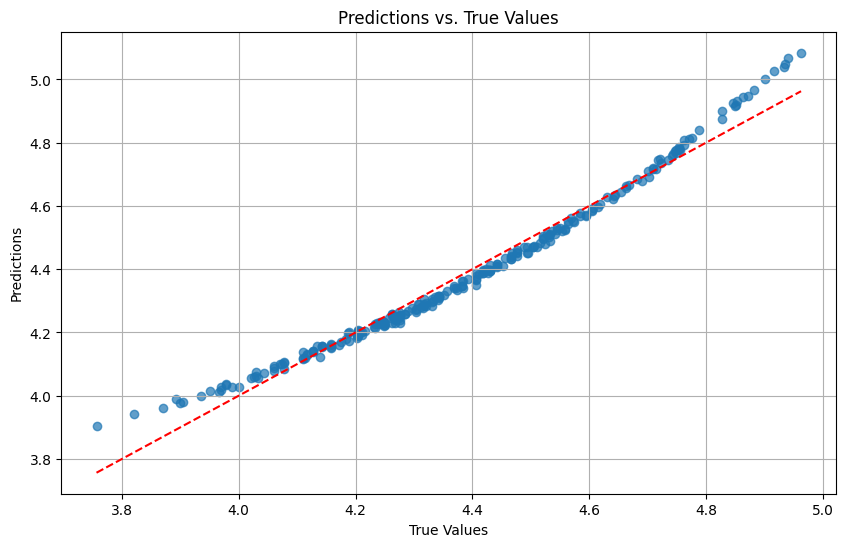

In [74]:
# Chart creation 
plt.figure(figsize=(10, 6))
plt.scatter(true_values_fromscratch, predictions_fromscratch, alpha=0.7)
plt.plot([min(true_values_fromscratch), max(true_values_fromscratch)], [min(true_values_fromscratch), max(true_values_fromscratch)], color='red', linestyle='--')
plt.title('Predictions vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show()

##### b. Residuals Graph

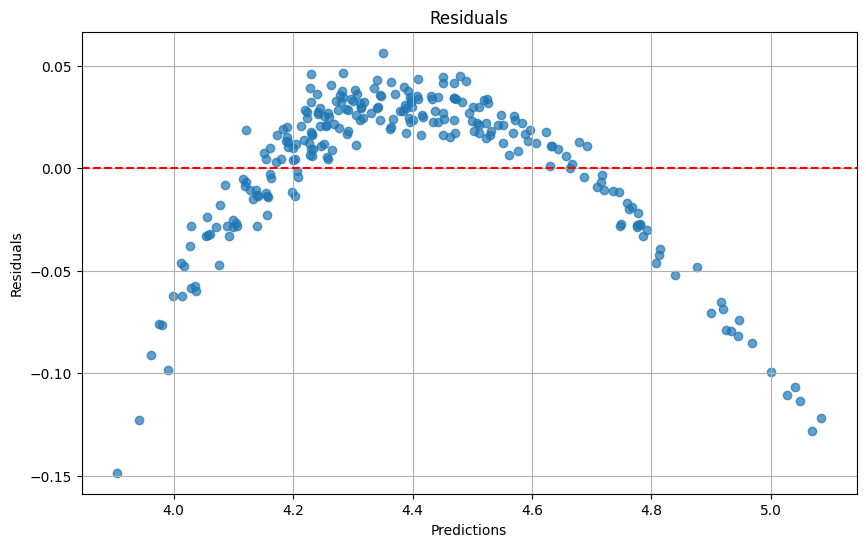

In [75]:
# Residuals calculation
residuals = true_values_fromscratch - predictions_fromscratch

# Graph creation 
plt.figure(figsize=(10, 6))
plt.scatter(predictions_fromscratch, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.grid()
plt.show()


## II - Ridge Regression with Scikit-learn 

### 1. Run the Model of Scikit-learn

In [76]:
def runRidgeRegressionScikitLearn():    
    # Load the preprocessed data 
    data = load_and_preprocess_ozone()

    # Apply the logarithmic transformation to maxO3
    data['log_maxO3'] = np.log(data['maxO3'])

    # Remove features that are too closely correlated
    ozone_data = remove_unimportant_features(data)

    X = ozone_data.drop('log_maxO3', axis=1)  # Features
    y = ozone_data['log_maxO3']  # Target variable

    # Split the data into training and testing sets (80% | 20%)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Apply PCA to reduce dimensionality
    pca = PCA(n_components=0.8)  
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    # Hyperparameter tuning with RandomizedSearchCV
    ridge = Ridge()
    param_grid = {
        'alpha': [0.1, 1.0, 5.0, 10.0, 30.0, 50.0, 70.0, 90.0, 100.0],  
        'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag', 'saga'], 
        'fit_intercept': [True, False],
        'max_iter': [1000, 1500, 2000],
        'tol': [1e-4, 1e-5]
    }
    random_search = RandomizedSearchCV(ridge, param_grid, cv=5, scoring='neg_mean_squared_error')
    random_search.fit(X_train_pca, y_train)

    # Best parameters  
    best_params = random_search.best_params_
    print("Best parameters :", best_params)

    # Best model
    best_model = random_search.best_estimator_

    # Train with the best model
    best_model.fit(X_train_pca, y_train)

    # Make predictions on the test data
    predictions_scikitlearn = best_model.predict(X_test_pca)

    # Display the first 10 predictions and true values
    print("First 10 Predictions (scikit-learn):", predictions_scikitlearn[:10])
    print("First 10 True Values:", y_test.values[:10])

    return best_model, predictions_scikitlearn, y_test.values  # Return the predicted and true values

### 2. Ridge Regression With Scikit-learn Performance Evaluation

In [77]:
# Start the timer 
start_time_scikitlearn = time.time()

# Run the Ridge Regression function
model_scikitlearn, predictions_scikitlearn, true_values_scikitlearn = runRidgeRegressionScikitLearn() 

# Execution time calculation 
execution_time_scikitlearn = time.time() - start_time_scikitlearn

# Metrics calculation
mse_scikitlearn = mean_squared_error(true_values_scikitlearn, predictions_scikitlearn)
rmse_scikitlearn = np.sqrt(mse_scikitlearn)
mae_scikitlearn = mean_absolute_error(true_values_scikitlearn, predictions_scikitlearn)
r2_scikitlearn = r2_score(true_values_scikitlearn, predictions_scikitlearn)

# Display the results
print(f'Execution Time: {execution_time_scikitlearn}')
print(f'Mean Squared Error (MSE): {mse_scikitlearn}')
print(f'Root Mean Squared Error (RMSE): {rmse_scikitlearn}')
print(f"Mean Absolute Error: {mae_scikitlearn}")
print(f'R2 Score (R²): {r2_scikitlearn}')

Columns to drop due to high correlation: {'T12', 'Ne18', 'T9', 'Ne15', 'Vvit12', 'Vvit15', 'T15', 'Ne12', 'T18'}
Columns to drop due to low correlation with the target: ['T6', 'Vvit18']
Best parameters : {'tol': 0.0001, 'solver': 'cholesky', 'max_iter': 1000, 'fit_intercept': True, 'alpha': 30.0}
First 10 Predictions (scikit-learn): [4.45604992 4.2958609  4.99145078 4.19147577 4.44035842 4.46725999
 4.14683226 4.41103985 4.19089087 4.59759179]
First 10 True Values: [4.52178858 4.31748811 4.90082043 4.29045944 4.54329478 4.53259949
 4.10758979 4.50202943 4.2341065  4.59107126]
Execution Time: 0.16681671142578125
Mean Squared Error (MSE): 0.004368065762751712
Root Mean Squared Error (RMSE): 0.06609134408341014
Mean Absolute Error: 0.048227835842252736
R2 Score (R²): 0.9309491233401802


In [78]:
# Cross validation 

# Use cross-validation to get predictions
cv_predictions = cross_val_predict(model_scikitlearn, X_train, y_train, cv=5)

# Calculate metrics for cross-validation predictions
mse_cv = mean_squared_error(y_train, cv_predictions)
rmse_cv = np.sqrt(mse_cv)
mae_cv = mean_absolute_error(y_train, cv_predictions)
r2_cv = r2_score(y_train, cv_predictions)

# Display the results for cross-validation
print(f'Cross-Validated Mean Squared Error (MSE): {mse_cv:.4f}')
print(f'Cross-Validated Root Mean Squared Error (RMSE): {rmse_cv:.4f}')
print(f'Cross-Validated Mean Absolute Error: {mae_cv:.4f}')
print(f'Cross-Validated R² Score (R²): {r2_cv:.4f}')

Cross-Validated Mean Squared Error (MSE): 0.0018
Cross-Validated Root Mean Squared Error (RMSE): 0.0429
Cross-Validated Mean Absolute Error: 0.0300
Cross-Validated R² Score (R²): 0.9716


### 3. Displaying Model Results 

#### a- Predictions vs. True Values Chart

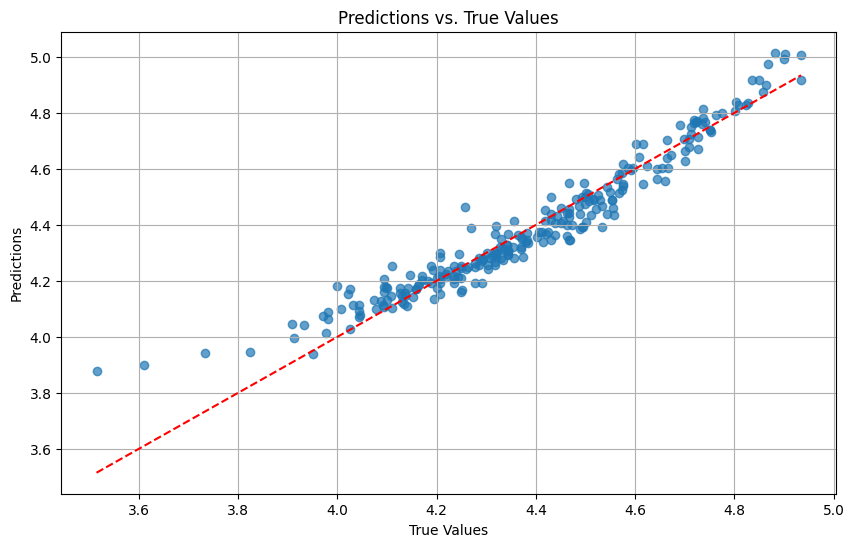

In [79]:
# Chart creation 
plt.figure(figsize=(10, 6))
plt.scatter(true_values_scikitlearn, predictions_scikitlearn, alpha=0.7)
plt.plot([min(true_values_scikitlearn), max(true_values_scikitlearn)], [min(true_values_scikitlearn), max(true_values_scikitlearn)], color='red', linestyle='--')
plt.title('Predictions vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid()
plt.show() 

#### b- Residuals Graph

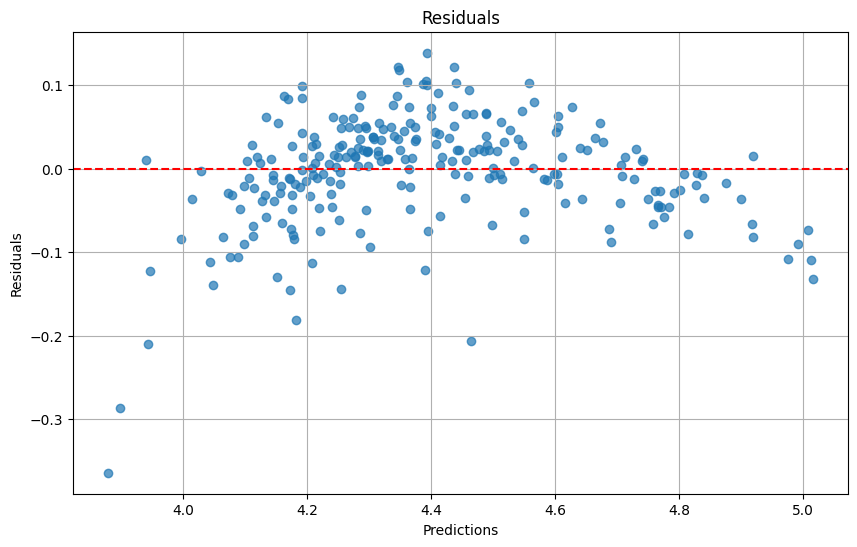

In [80]:
# Residuals calculation
residuals_scikitlearn = true_values_scikitlearn - predictions_scikitlearn

# Graph creation 
plt.figure(figsize=(10, 6))
plt.scatter(predictions_scikitlearn, residuals_scikitlearn, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.grid()
plt.show()